In [3]:
!pip install --use-pep517 lightning torch torch-geometric tensorboard nbformat "jsonargparse[signatures]" ipywidgets tabulate
!pip install git+https://github.com/a-r-j/graphein.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.2/824.2 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.2/828.2 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.4 MB/s eta 0:00:00
  Cloning https://github.com/a-r-j/graphein.git to /tmp/pip-req-build-ec297ct5
  Running command git clone --filter=blob:none --quiet https://github.com/a-r-j/graphein.git /tmp/pip-req-build-ec297ct5
  Resolved https://github.com/a-r-j/graphein.git to commit 9a47dafb356640b47b537b302c6f072afb7a81c7
  Installing build dependencies ... done
  Getting requiremen

In [1]:
import graphein
graphein.verbose(enabled=False)
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.graphs import construct_graph
from graphein.protein.features.nodes import amino_acid as graphein_nodes
from graphein.protein import edges as graphein_edges
from graphein.protein.subgraphs import extract_subgraph
from graphein.protein.visualisation import plotly_protein_structure_graph
from functools import partial
from matplotlib import colormaps
import pandas as pd
from pathlib import Path

#### START: For Colab

In [2]:
# ONLY FOR COLAB!
import gdown
gdown.download(id="1assQw7HSd7ErD0xOWqakLcm-o_5X-xL6", output="hackathon_data.zip")

Downloading...
From (original): https://drive.google.com/uc?id=1assQw7HSd7ErD0xOWqakLcm-o_5X-xL6
From (redirected): https://drive.google.com/uc?id=1assQw7HSd7ErD0xOWqakLcm-o_5X-xL6&confirm=t&uuid=79460fed-66b3-461e-b68f-0fcfe60589ea
To: /content/hackathon_data.zip
100%|██████████| 344M/344M [00:02<00:00, 156MB/s]


'hackathon_data.zip'

In [3]:
!unzip -qq hackathon_data.zip
!mv "scicore/home/schwede/durair0000/projects/vib-ai-course/ml-ai-summer-school-vib/1_graphs_interface/data/hackathon_data" .
!rm -rf scicore/

#### END: For Colab

In [4]:
# DATA_DIR = Path("../data/hackathon_data/") # Uncomment for HPC
DATA_DIR = Path("hackathon_data/")

In [5]:
df = pd.read_csv(DATA_DIR / "data.csv")
df["holo_filenames"] = df["pinder_id"].apply(lambda x: f"{x.split('--')[0]}-R--{x.split('--')[1]}-L.pdb")
df["holo_paths"] = df[["split", "pinder_id", "holo_filenames"]].apply(lambda x: DATA_DIR / x["split"] / x["pinder_id"] / x["holo_filenames"], axis=1)
df.head()

,pinder_id,pred_pinder_id,split,holo_filenames,holo_paths
0,4dhx__B1_Q9NPA8--4dhx__A1_O60318,af__Q9NPA8--af__O60318,train,4dhx__B1_Q9NPA8-R--4dhx__A1_O60318-L.pdb,hackathon_data/train/4dhx__B1_Q9NPA8--4dhx__A1...
1,6avz__A1_H6A3H4--6avz__B1_P40198,af__H6A3H4--af__P40198,train,6avz__A1_H6A3H4-R--6avz__B1_P40198-L.pdb,hackathon_data/train/6avz__A1_H6A3H4--6avz__B1...
2,5vkd__B1_UNDEFINED--5vkd__A1_B8XCM7,NaN,train,5vkd__B1_UNDEFINED-R--5vkd__A1_B8XCM7-L.pdb,hackathon_data/train/5vkd__B1_UNDEFINED--5vkd_...
3,6i2m__B1_Q13618--6i2m__A1_P24768,NaN,train,6i2m__B1_Q13618-R--6i2m__A1_P24768-L.pdb,hackathon_data/train/6i2m__B1_Q13618--6i2m__A1...
4,4p2c__A1_Q7WUF4--4p2c__I1_R9VYW2,af__Q7WUF4--af__R9VYW2,train,4p2c__A1_Q7WUF4-R--4p2c__I1_R9VYW2-L.pdb,hackathon_data/train/4p2c__A1_Q7WUF4--4p2c__I1...


In [6]:
test_filename = df["holo_paths"].values[0]
test_filename

PosixPath('hackathon_data/train/4dhx__B1_Q9NPA8--4dhx__A1_O60318/4dhx__B1_Q9NPA8-R--4dhx__A1_O60318-L.pdb')

## Converting proteins to featurized graphs

The [graphein](https://graphein.ai/) library provides functionality for producing a number of types of graph-based representations of proteins. We'll use it to construct [NetworkX](https://github.com/networkx/networkx) graphs from protein structures, extract interface residues, and to featurise the nodes and edges of the graph

Here we use the node features implemented in `graphein.protein.features.nodes.amino_acid`, but there's many more kinds of node features available in the library (see the full [API](https://graphein.ai/modules/graphein.protein.html#features))

In [7]:
graph_config = ProteinGraphConfig(
    verbose=True,
    node_metadata_functions = [graphein_nodes.amino_acid_one_hot, graphein_nodes.meiler_embedding],
    edge_construction_functions = [graphein_edges.add_peptide_bonds, partial(graphein_edges.add_distance_threshold,
                                                                             threshold=8.0,
                                                                             long_interaction_threshold=2)]
                                                                             )

In [8]:
graph = construct_graph(path=test_filename,
                        config=graph_config)

Output()

Now we have a graph object consisting of nodes and edges, each associated with the attributes we've specified

In [9]:
i = 0
for (node, node_data) in graph.nodes(data=True):
  print("Node:", node)
  print("Node attributes:", node_data)
  if i > 5:
    break
  i += 1

Node: L:LEU:3
Node attributes: {'chain_id': 'L', 'residue_name': 'LEU', 'residue_number': 3, 'atom_type': 'CA', 'element_symbol': 'C', 'coords': array([ -2.633, -51.392, -44.506], dtype=float32), 'b_factor': 65.44999694824219, 'amino_acid_one_hot': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'meiler': dim_1    2.59
dim_2    0.19
dim_3    4.00
dim_4    1.70
dim_5    6.04
dim_6    0.39
dim_7    0.31
Name: LEU, dtype: float64}
Node: L:VAL:4
Node attributes: {'chain_id': 'L', 'residue_name': 'VAL', 'residue_number': 4, 'atom_type': 'CA', 'element_symbol': 'C', 'coords': array([ -0.885, -49.832, -41.513], dtype=float32), 'b_factor': 65.30999755859375, 'amino_acid_one_hot': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]), 'meiler': dim_1    3.67
dim_2    0.14
dim_3    3.00
dim_4    1.22
dim_5    6.02
dim_6    0.27
dim_7    0.49
Name: VAL, dtype: float64}
Node: L:LEU:5
Node attributes: {'chain_id': 'L', 'residue_name': 'LEU', 'residue_number': 5, '

In [10]:
i = 0
for (start_node, end_node, edge_data) in graph.edges(data=True):
  print(f"Edge between {start_node} and {end_node}")
  print("Edge attributes:", edge_data)
  if i > 5:
    break
  i += 1

Edge between L:LEU:3 and L:VAL:4
Edge attributes: {'kind': {'peptide_bond'}, 'distance': 3.8009400467200534}
Edge between L:LEU:3 and L:LEU:5
Edge attributes: {'kind': {'distance_threshold'}, 'distance': 6.114622001900332}
Edge between L:VAL:4 and L:LEU:5
Edge attributes: {'kind': {'peptide_bond'}, 'distance': 3.8028423589738156}
Edge between L:VAL:4 and L:SER:6
Edge attributes: {'kind': {'distance_threshold'}, 'distance': 5.837326756278535}
Edge between L:VAL:4 and L:GLU:7
Edge attributes: {'kind': {'distance_threshold'}, 'distance': 7.4221512573016275}
Edge between L:LEU:5 and L:SER:6
Edge attributes: {'kind': {'peptide_bond'}, 'distance': 3.790443999136919}
Edge between L:LEU:5 and L:GLU:7
Edge attributes: {'kind': {'distance_threshold'}, 'distance': 7.028968096980795}


In [11]:
p = plotly_protein_structure_graph(
    graph,
    colour_edges_by="kind",
    colour_nodes_by='chain_id',
    label_node_ids=False,
    node_size_multiplier=1
    )
p.show()

We can extract interface residues from this graph by checking for edges between chains:

In [12]:
interface_residues = set()
for source, target, kind in graph.edges(data=True):
    if 'distance_threshold' in kind['kind']:
        source_chain = source.split(":")[0]
        target_chain = target.split(":")[0]
        if source_chain != target_chain:
            if source_chain == "R":
                interface_residues.add(source)
            elif target_chain == "R":
                interface_residues.add(target)
interface_residues

{'R:ARG:13',
 'R:ARG:34',
 'R:ARG:76',
 'R:ARG:92',
 'R:CYS:50',
 'R:GLY:75',
 'R:ILE:54',
 'R:ILE:71',
 'R:ILE:91',
 'R:LEU:33',
 'R:LEU:46',
 'R:LEU:59',
 'R:LEU:67',
 'R:LEU:87',
 'R:LEU:88',
 'R:LYS:30',
 'R:LYS:43',
 'R:LYS:47',
 'R:LYS:51',
 'R:LYS:84',
 'R:THR:63',
 'R:THR:72',
 'R:VAL:64',
 'R:VAL:68'}

This information can be added to the graph as an `interface_label` node feature:

In [13]:
for node, data in graph.nodes(data=True):
  if node in interface_residues:
    data['interface_label'] = 1
  else:
    data['interface_label'] = 0

Let's see where the interface is for this example:

In [14]:
p = plotly_protein_structure_graph(
    graph,
    colour_edges_by='kind',
    colour_nodes_by='interface_label',
    label_node_ids=False,
    edge_color_map=colormaps['Pastel2'],
    node_size_multiplier=1
    )
p.show()

Since our task is to predict interface residues given just one input chain, we'll extract the subgraph for the chain of interest:

In [15]:
chain_subgraph = extract_subgraph(graph, chains="R")

p = plotly_protein_structure_graph(
    chain_subgraph,
    colour_edges_by="kind",
    colour_nodes_by="interface_label",
    label_node_ids=False,
    edge_color_map=colormaps['Pastel2'],
    plot_title="Peptide backbone graph. Nodes coloured by interface_label.",
    node_size_multiplier=1
    )
p.show()

We put all this together in a function to use in the later notebooks. Feel free to add other node features, edge types, and edge features to your function.

In [16]:
def load_graph(path, chain):
    graph_config = ProteinGraphConfig(
        node_metadata_functions = [graphein_nodes.amino_acid_one_hot, graphein_nodes.meiler_embedding],
        edge_construction_functions = [graphein_edges.add_peptide_bonds,
                                       partial(graphein_edges.add_distance_threshold,
                                               threshold=8.,
                                               long_interaction_threshold=2)],
    )
    graph = construct_graph(path=path, config=graph_config, verbose=False)
    interface_residues = set()
    for source, target, kind in graph.edges(data=True):
        c1, c2 = source.split(":")[0], target.split(":")[0]
        if 'distance_threshold' in kind['kind']:
            if c1 != c2:
                if c1 == chain:
                    interface_residues.add(source)
                elif c2 == chain:
                    interface_residues.add(target)
    graph = extract_subgraph(graph, chains=chain)
    for node, data in graph.nodes(data=True):
        if node in interface_residues:
            data['interface_label'] = 1
        else:
            data['interface_label'] = 0
    return graph

## Bonus


We can also add our own edge functions or node features that are not implemented in the graphein API. For example, we can calculate the solvent accessible surface area (SASA) for each residue and include it in as a node feature.

In [17]:
from Bio.PDB import PDBParser
from Bio.PDB.SASA import ShrakeRupley
from pathlib import Path
import warnings
warnings.filterwarnings("ignore") # to ignore warnings when parsing pdb structures

def add_sasa(path, graph, chain):
    struct = PDBParser().get_structure(Path(path).stem, path)[0][chain] # Only get one chain
    sr = ShrakeRupley()
    sr.compute(struct, level="R") # residue level
    for _, data in graph.nodes(data=True):
        # add SASA to node features
        data['sasa'] = struct[data['residue_number']].sasa
    return graph

graph = load_graph(test_filename, "R")
graph = add_sasa(test_filename, graph, "R")

In [18]:
i = 0
for (node, node_data) in graph.nodes(data=True):
    print("Node:", node)
    print("Node attributes:", node_data)
    if i > 5:
        break
    i += 1

Node: R:ASP:9
Node attributes: {'chain_id': 'R', 'residue_name': 'ASP', 'residue_number': 9, 'atom_type': 'CA', 'element_symbol': 'C', 'coords': array([ 12.415, -47.491, -32.49 ], dtype=float32), 'b_factor': 89.8499984741211, 'amino_acid_one_hot': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'meiler': dim_1    1.60
dim_2    0.11
dim_3    2.78
dim_4   -0.77
dim_5    2.95
dim_6    0.25
dim_7    0.20
Name: ASP, dtype: float64, 'interface_label': 0, 'sasa': 126.42810590169259}
Node: R:ALA:10
Node attributes: {'chain_id': 'R', 'residue_name': 'ALA', 'residue_number': 10, 'atom_type': 'CA', 'element_symbol': 'C', 'coords': array([ 12.75 , -44.29 , -30.458], dtype=float32), 'b_factor': 79.44000244140625, 'amino_acid_one_hot': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'meiler': dim_1    1.28
dim_2    0.05
dim_3    1.00
dim_4    0.31
dim_5    6.11
dim_6    0.42
dim_7    0.23
Name: ALA, dtype: float64, 'interface_label': 0, 'sasa': 73.5521233119

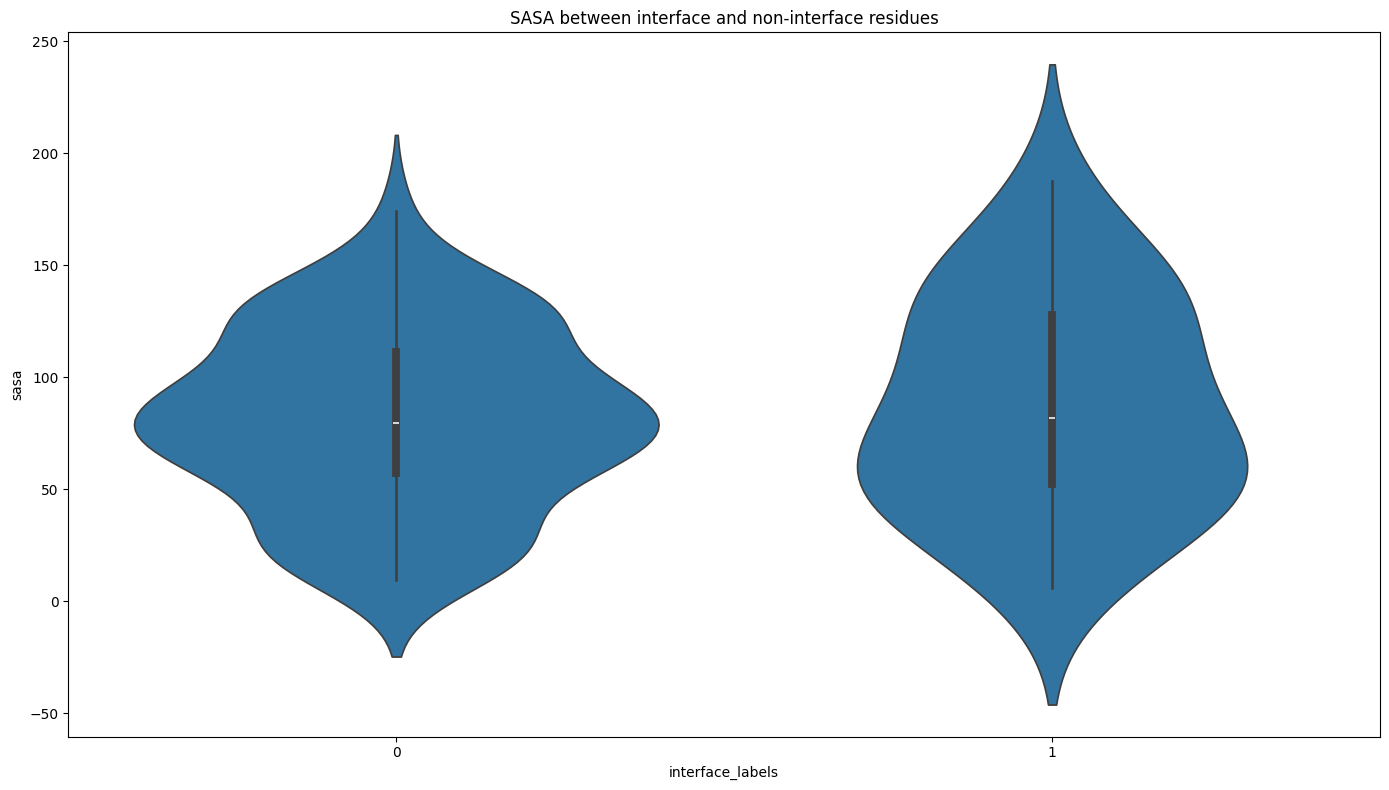

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sasa, interface_labels = [], []
for (node, node_data) in graph.nodes(data=True):
    sasa.append(node_data['sasa'])
    interface_labels.append(node_data['interface_label'])
data = {
    "sasa": sasa,
    "interface_labels": interface_labels
}

plt.figure(figsize=(14, 8))
sns.violinplot(x="interface_labels", y="sasa", data=data)
plt.title("SASA between interface and non-interface residues")
plt.tight_layout()
plt.show()

**What other node or edge features would you like to include in your graph?**

## Converting graphs to deep learning datasets

Deep learning libraries like PyTorch, and by extension PyTorch-Geometric, have some standardized ways of handling data and datasets, in order to optimize the operations they perform on the various numeric features involved. In this notebook, we will see how to convert a graph into a torch `Data` object, which is the standard way of representing a graph in PyTorch-Geometric. Then we'll go from a single graph to a `Dataset` of graphs, which is the standard way of representing a dataset in PyTorch. And finally, we'll see how to wrap this `Dataset` into a Lightning `DataModule`, which is the standard way of handling data-related operations in PyTorch-Lightning.

### Data

We first need to make a torch `Data` object from our graphs. This is easily done with graphein's conversion functions, specifically the `GraphFormatConvertor`, where you can specify which features of the NetworkX graph you'd like to retain in the `Data` object.

In [20]:
from graphein.ml import GraphFormatConvertor

In [21]:
columns = [
            "chain_id",
            "coords",
            "edge_index",
            "node_id",
            "residue_number",
            "amino_acid_one_hot",
            "meiler",
            "interface_label"
]
convertor = GraphFormatConvertor(src_format="nx", # From NetworkX
                                 dst_format="pyg", # To PyTorch Geometric
                                 columns=columns, # The columns to be used
                                 verbose=None)
graphein_graph = load_graph(test_filename, "R")
torch_data = convertor(graphein_graph)

In [22]:
torch_data

Data(edge_index=[2, 730], node_id=[91], chain_id=[91], residue_number=[91], coords=[91, 3], amino_acid_one_hot=[91, 20], meiler=[91, 7], interface_label=[91], num_nodes=91)

In [23]:
list(zip(torch_data.node_id[:5], torch_data.interface_label[:5]))

[('R:ASP:9', tensor(0)),
 ('R:ALA:10', tensor(0)),
 ('R:GLN:11', tensor(0)),
 ('R:MET:12', tensor(0)),
 ('R:ARG:13', tensor(1))]

In [24]:
torch_data.edge_index.T[:5]

tensor([[0, 1],
        [0, 2],
        [0, 3],
        [0, 4],
        [1, 0]])

For example, here are the amino acid types across interface and non-interface residues:

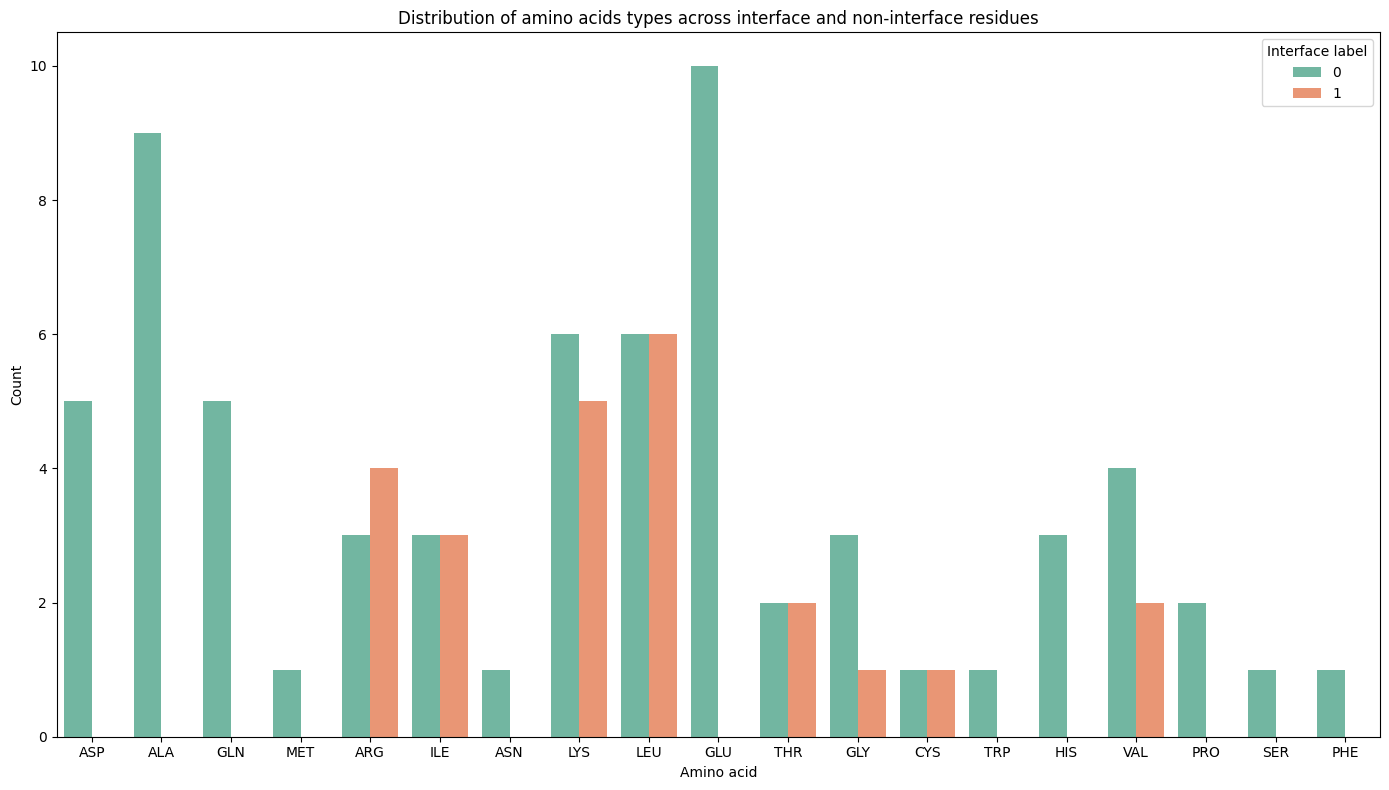

In [25]:
extracted_amino_acids = [s.split(":")[1] for s in torch_data.node_id]

data_with_aa = {"amino acid": extracted_amino_acids, "interface labels": torch_data.interface_label}

plt.figure(figsize=(14, 8))
sns.countplot(x="amino acid", hue="interface labels", data=data_with_aa, palette="Set2")
plt.title("Distribution of amino acids types across interface and non-interface residues")
plt.ylabel("Count")
plt.xlabel("Amino acid")
plt.legend(title="Interface label", loc='upper right')
plt.tight_layout()
plt.show()

We can use the `to_networkx` function to convert the `Data` object back to a NetworkX graph

In [26]:
from torch_geometric.utils import to_networkx

nx_graph_again = to_networkx(torch_data,
                                   node_attrs=["chain_id",
                                               "coords",
                                               "node_id",
                                               "residue_number",
                                               "amino_acid_one_hot",
                                               "meiler",
                                               "interface_label"],
                                    to_undirected=True)

In [27]:
p = plotly_protein_structure_graph(
    nx_graph_again,
    colour_edges_by=None,
    colour_nodes_by='interface_label',
    label_node_ids=False,
    node_size_multiplier=1
    )
p.show()

### Dataset

The `torch_geometric.data.Dataset` class is a standard way of representing a graph dataset in PyTorch. It is an abstract class that you can subclass to create your own dataset. The functions that need to be included are:

- `download()`: this downloads the dataset (in our case from `dataset.txt`) and saves each data point (in our case as a pickle file containing the graphein graph that our `load_graph` function returns) in `self.raw_dir`.
- `process()`: this processes the data from `self.raw_dir` to torch-geometric `Data` objects (as we did above), and saves them as `.pt` files in `self.processed_dir`.
- property functions: `raw_file_names`, `processed_file_names` return the names of the raw pickle and processed pt files for each data point.
- `len()`: this returns the number of graphs in the dataset
- `get()`: this returns the `Data` object for a given index

See the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Dataset.html#torch_geometric.data.Dataset) for more.

In [28]:
import pickle
import torch
from torch_geometric.data import Dataset
from tqdm import tqdm

class ProteinDataset(Dataset):
    """
    torch-geometric Dataset class for loading protein files as graphs.
    """
    def __init__(self, root, paths: list):
        columns = [
            "chain_id",
            "coords",
            "edge_index",
            "kind",
            "node_id",
            "residue_number",
            "amino_acid_one_hot",
            "meiler",
            "interface_label",
        ]
        self.convertor = GraphFormatConvertor(src_format="nx", dst_format="pyg", columns=columns, verbose=None)
        self.paths = []
        for path in paths:
            self.paths.append((path, path.stem.split("--")[0], "R"))
            self.paths.append((path, path.stem.split("--")[1], "L"))
        super(ProteinDataset, self).__init__(root)

    def download(self):
        for path, name, chain in tqdm(self.paths):
            output = Path(self.raw_dir) / f'{name}-{chain}.pkl'
            if not output.exists():
                graphein_graph = load_graph(path, chain)
                with open(output, "wb") as f:
                    pickle.dump(graphein_graph, f)

    @property
    def raw_file_names(self):
        return [Path(self.raw_dir) / f"{name}-{chain}.pkl" for _, name, chain in self.paths]

    @property
    def processed_file_names(self):
        return [Path(self.processed_dir) / f"{name}-{chain}.pt" for _, name, chain in self.paths]

    def process(self):
        for _, name, chain in tqdm(self.paths):
            output = Path(self.processed_dir) / f'{name}-{chain}.pt'
            if not output.exists():
                with open(Path(self.raw_dir) / f"{name}-{chain}.pkl", "rb") as f:
                    graphein_graph = pickle.load(f)
                torch_data = self.convertor(graphein_graph)
                torch.save(torch_data, output)

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(self.processed_file_names[idx], weights_only=False)
        return data


In [29]:
paths = df["holo_paths"].values[:10]
dataset = ProteinDataset(root='./test_data', paths=paths)

100%|██████████| 20/20 [00:04<00:00,  4.29it/s]
Processing...
100%|██████████| 20/20 [00:00<00:00, 30.84it/s]
Done!


In [30]:
dataset

ProteinDataset(20)

In [31]:
dataset[0]

Data(edge_index=[2, 730], node_id=[91], chain_id=[91], residue_number=[91], coords=[91, 3], amino_acid_one_hot=[91, 20], meiler=[91, 7], interface_label=[91], kind=[365], num_nodes=91)

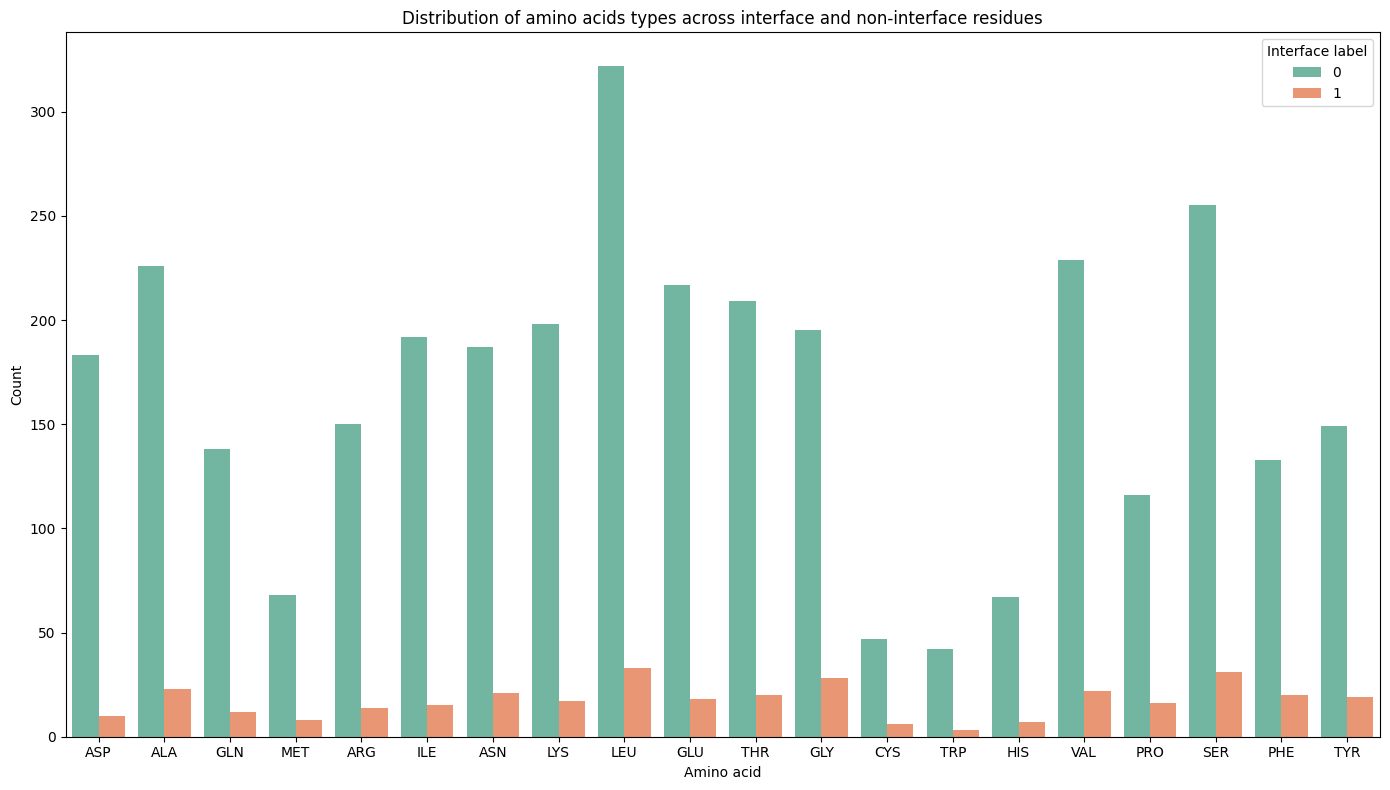

In [32]:
all_amino_acids = []
all_interface_labels = []

for torch_graph in dataset:
    extracted_amino_acids = [s.split(":")[1] for s in torch_graph.node_id]
    all_amino_acids.extend(extracted_amino_acids)
    all_interface_labels.extend(torch_graph.interface_label.tolist())

data_with_aa = {
    "amino acid": all_amino_acids,
    "interface labels": all_interface_labels
}

plt.figure(figsize=(14, 8))
sns.countplot(x="amino acid", hue="interface labels", data=data_with_aa, palette="Set2")
plt.title("Distribution of amino acids types across interface and non-interface residues")
plt.ylabel("Count")
plt.xlabel("Amino acid")
plt.legend(title="Interface label", loc='upper right')
plt.tight_layout()
plt.show()

Graphein also has a built-in `ProteinGraphDataset` class that combines these steps. It also has some nice features like
- the ability to load a dataset of proteins from both the PDB or AlphaFold Database directory of PDB files
- the ability to apply custom transformations from your bioinformatics tools of choice to the PDB files (with the `pdb_transform` argument).

### DataModule

Now that we have our `Dataset` ready, we need to specificy how the `Data` objects within the created Dataset are split into training, validation and test sets. This is where PyTorch Lightning's DataModule comes in ([documentation](https://lightning.ai/docs/pytorch/stable/data/datamodule.html)). The `DataModule` is a class that encapsulates the logic for loading, batching and splitting the data. It's a way of separating the logic for data loading and batching separate from both the data ingestion and the model and training logic, which makes the code more modular and easier to maintain. It also makes it easier to switch between different datasets and data loading strategies.

To define a `DataModule` the following methods are necessary:
- `prepare_data()` - this defines the downloading and IO operations that are generally slower and need to only be run once. In our case it just runs the Dataset function once to download and process all the pickle and pt files. This is called once in the beginning of training so all the future calls of Dataset in setup (which is called on every node/process) just loads the data from the saved files.
- `setup()` - this defines how to split the dataset. It also takes a `stage` argument (one of `fit,validate,test,predict`).
- `train_dataloader()` - this returns the `DataLoader` for the training data

and the following are optional:
- `val_dataloader()` - this returns the `DataLoader` for the validation data
- `test_dataloader()` - this returns the `DataLoader` for the test data
- `predict_dataloader()` - this returns the `DataLoader` for the inference data

In [33]:
from lightning.pytorch import LightningDataModule
from torch_geometric.loader import DataLoader

class ProteinGraphDataModule(LightningDataModule):
    def __init__(self, root, dataset_file, batch_size=8):
        super().__init__()
        self.root = root
        self.dataset = pd.read_csv(dataset_file)
        self.dataset["holo_filenames"] = self.dataset["pinder_id"].apply(lambda x: f"{x.split('--')[0]}-R--{x.split('--')[1]}-L.pdb")
        self.dataset["holo_paths"] = self.dataset[["split", "pinder_id", "holo_filenames"]].apply(lambda x: dataset_file.parent / x["split"] / x["pinder_id"] / x["holo_filenames"], axis=1)
        self.batch_size = batch_size

    def prepare_data(self):
        for split in self.dataset["split"].unique():
            ProteinDataset(root=self.root, paths=self.dataset[self.dataset["split"] == split]["holo_paths"].values[:10])

    def setup(self, stage):
        self.train = ProteinDataset(root=self.root, paths=self.dataset[self.dataset["split"] == "train"]["holo_paths"].values[:10])
        self.val = ProteinDataset(root=self.root, paths=self.dataset[self.dataset["split"] == "val"]["holo_paths"].values[:10])
        self.test = ProteinDataset(root=self.root, paths=self.dataset[self.dataset["split"] == "test"]["holo_paths"].values[:10])

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size)

The `DataModule` is now ready, give it a try and loop through the dataloader to see how they work!

In [34]:
datamodule = ProteinGraphDataModule("./test_data", DATA_DIR / "data.csv")
datamodule.prepare_data()
datamodule.setup("fit")

train_loader = datamodule.train_dataloader()
example_train_protein = datamodule.train[0]
example_train_batch = next(iter(train_loader))

100%|██████████| 20/20 [00:00<00:00, 18604.14it/s]
Processing...
100%|██████████| 20/20 [00:00<00:00, 18279.82it/s]
Done!
100%|██████████| 20/20 [00:06<00:00,  2.88it/s]
Processing...
100%|██████████| 20/20 [00:00<00:00, 47.46it/s]
Done!
100%|██████████| 20/20 [00:05<00:00,  3.66it/s]
Processing...
100%|██████████| 20/20 [00:00<00:00, 56.17it/s]
Done!
100%|██████████| 20/20 [00:00<00:00, 26206.21it/s]
Processing...
100%|██████████| 20/20 [00:00<00:00, 29475.08it/s]
Done!
100%|██████████| 20/20 [00:00<00:00, 29927.25it/s]
Processing...
100%|██████████| 20/20 [00:00<00:00, 29568.59it/s]
Done!
100%|██████████| 20/20 [00:00<00:00, 19901.80it/s]
Processing...
100%|██████████| 20/20 [00:00<00:00, 21794.25it/s]
Done!


We have an example train data point (`example_train_protein`) but training is almost always done on batches of data points controlled by the `batch_size`. This batch size defines the number of input graphs looked at in each iteration of the training process (one forward and backward pass). It has a trade-off between the speed of the training and the generalizability of the model.

In the graph neural network setting, a batch essentially combines all the graphs of the individual proteins into a bigger graph, with an additional batch attribute that specifies which protein each node belongs to. Since there are no edges between the different proteins, training on this batch graph is equivalent to training on the individual graphs separately, since no information flows between the different proteins. This is what is returned by the `train_dataloader` of the `DataModule`, in `example_train_batch`.

Let's check what each of variables contain.

In [35]:
example_train_protein

Data(edge_index=[2, 730], node_id=[91], chain_id=[91], residue_number=[91], coords=[91, 3], amino_acid_one_hot=[91, 20], meiler=[91, 7], interface_label=[91], kind=[365], num_nodes=91)

In [36]:
example_train_batch

DataBatch(edge_index=[2, 13764], node_id=[8], chain_id=[8], residue_number=[1488], coords=[1488, 3], amino_acid_one_hot=[1488, 20], meiler=[1488, 7], interface_label=[1488], kind=[8], num_nodes=1488, batch=[1488], ptr=[9])

## PyTorch-Geometric models and layers

Now that we have our data ready, we'll take a look at some of the different architectures and building block layers that are implemented in the `torch-geometric` library, and how they can be used to build and train models for graph-based tasks.

- [torch_geometric.nn](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html) has a variety of graph layers that can be used to build custom GNN architectures. These include:
    - [Convolutional layers](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers): These define how the message passing step is accomplished across edges in the graph. `GCNConv` is a simple example of a graph convolution layer, while `GATConv` is a more complex example with attention mechanisms.
    - [Aggregation Operators](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#aggregation-operators): These define how messages are aggregated at each node.
    - [Pooling layers](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#id45): These define how nodes are aggregated into a single node.

- [torch_geometric.nn.models](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#models) has more complex model architectures with a variety of of these layers already defined and combined inside.
- The [PyGModelHubMixin](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.model_hub.PyGModelHubMixin) class can be used to load pre-trained models or other model architectures from the [HuggingFace Model Hub](https://huggingface.co/models?pipeline_tag=graph-ml&sort=trending)

### Graph neural network layers

Here's how we would define a graph convolutional layer that takes amino acid one hot embeddings as input node features along with the edge index to define the graph, and converts them to a 64-dimensional embedding via convolution operations across the graph:

In [37]:
from torch_geometric import nn as graph_nn
from torch import nn

In [38]:
layer = graph_nn.GCNConv(in_channels=20, out_channels=2)
example_output = layer(example_train_batch.amino_acid_one_hot.float(), example_train_batch.edge_index)
example_output.shape

torch.Size([1488, 2])

In [39]:
layer = graph_nn.GATConv(in_channels=20, out_channels=2)
example_output = layer(example_train_batch.amino_acid_one_hot.float(), example_train_batch.edge_index)
example_output.shape

torch.Size([1488, 2])

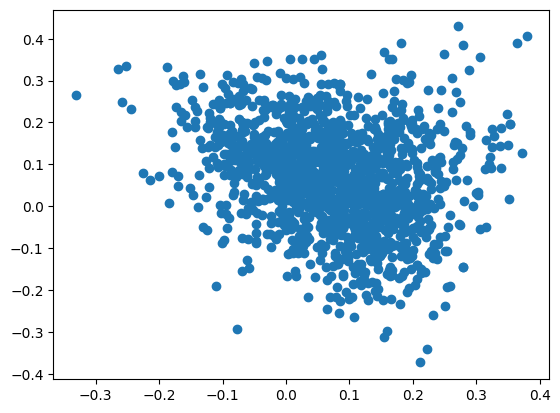

In [40]:
plt.scatter(example_output.detach().numpy()[:,0], example_output.detach().numpy()[:,1])

In [41]:
example_output.detach().numpy()[:,0]

array([ 0.10826805,  0.04236203,  0.00963243, ..., -0.07158256,
        0.12396509, -0.12563273], dtype=float32)

**Try out some of the other layers in the torch_geometric.nn module!**

### Graph neural network models

We can also try out some of the pre-defined models in the `torch_geometric.nn.models` module, such as the `GAT` model which applies a series of `GATv2Conv` layers that uses attention mechanisms to weight the importance of different nodes in the graph when aggregating information from neighbors, followed by a Linear layer to convert the node embeddings to a 64-dimensional output.

In [42]:
model = graph_nn.GAT(in_channels=20,
                     hidden_channels=32,
                     num_layers=3,
                     heads=2,
                     out_channels=64,
                     dropout=0.01,
                     jk="last",
                     v2=True)
print(graph_nn.summary(model, example_train_batch.amino_acid_one_hot.float(), example_train_batch.edge_index))
print(model(example_train_batch.amino_acid_one_hot.float(), example_train_batch.edge_index).shape)

+---------------------+------------------------+----------------+----------+
| Layer               | Input Shape            | Output Shape   | #Param   |
|---------------------+------------------------+----------------+----------|
| GAT                 | [1488, 20], [2, 13764] | [1488, 64]     | 7,872    |
| ├─(dropout)Dropout  | [1488, 32]             | [1488, 32]     | --       |
| ├─(act)ReLU         | [1488, 32]             | [1488, 32]     | --       |
| ├─(convs)ModuleList | --                     | --             | 5,760    |
| │    └─(0)GATv2Conv | [1488, 20], [2, 13764] | [1488, 32]     | 1,408    |
| │    └─(1)GATv2Conv | [1488, 32], [2, 13764] | [1488, 32]     | 2,176    |
| │    └─(2)GATv2Conv | [1488, 32], [2, 13764] | [1488, 32]     | 2,176    |
| ├─(norms)ModuleList | --                     | --             | --       |
| │    └─(0)Identity  | [1488, 32]             | [1488, 32]     | --       |
| │    └─(1)Identity  | [1488, 32]             | [1488, 32]     | --       |

**Try out some of the other models in the torch_geometric.nn module!**

We can combine layers into custom architectures. Here is an example of a simple architecture that uses a GATConv layer and a GCNConv layer with some activation functions in between, and finally a linear layer to convert the 64-dimensional node embeddings to one value per node.

In [43]:
model = graph_nn.Sequential('x, edge_index', [
    (graph_nn.GATConv(in_channels=20, out_channels=64, heads=2, concat=False), 'x, edge_index -> x'),
    nn.ReLU(),
    (graph_nn.GCNConv(in_channels=64, out_channels=64), 'x, edge_index -> x'),
    nn.ReLU(),
    nn.Linear(64, 1),
])

print(graph_nn.summary(model, example_train_batch.amino_acid_one_hot.float(), example_train_batch.edge_index))

+---------------------+------------------------+----------------+----------+
| Layer               | Input Shape            | Output Shape   | #Param   |
|---------------------+------------------------+----------------+----------|
| Sequential          | [1488, 20], [2, 13764] | [1488, 1]      | 7,105    |
| ├─(module_0)GATConv | [1488, 20], [2, 13764] | [1488, 64]     | 2,880    |
| ├─(module_1)ReLU    | [1488, 64]             | [1488, 64]     | --       |
| ├─(module_2)GCNConv | [1488, 64], [2, 13764] | [1488, 64]     | 4,160    |
| ├─(module_3)ReLU    | [1488, 64]             | [1488, 64]     | --       |
| ├─(module_4)Linear  | [1488, 64]             | [1488, 1]      | 65       |
+---------------------+------------------------+----------------+----------+


## Defining losses

In order to train such models with our data for our task of interface residue prediction, we need to define a loss function that takes the output of the model (the prediction) and the target labels and computes a loss value that the optimizer can use to update the model parameters. A typical choice for binary classification tasks is the binary cross entropy loss, which is implemented in PyTorch as `torch.nn.BCEWithLogitsLoss`. This loss function takes the raw output of the model and the target labels, and applies the sigmoid function to the model output to get the predicted probabilities, and then computes the binary cross entropy loss between the predicted probabilities and the target labels, defined as

$$
\text{loss} = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right]
$$

where $N$ is the number of residues, $y_i$ is the target label for residue $i$ (1 if it's an interface residue, 0 if not), and $p_i$ is the predicted probability for residue $i$.

In [44]:
nn.BCEWithLogitsLoss()(model(example_train_batch.amino_acid_one_hot.float(), example_train_batch.edge_index),
                       example_train_batch.interface_label.view(-1, 1).float())

tensor(0.7406, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

## Training a model

Given a model that predicts interface probabilities and a loss that compared them with the true interface labels, what we now need is a training loop that will iterate over the training data in batches, compute the loss, and use an optimizer to update the model parameters based on the loss value.

All of this is encapsulated within the `LightningModule` class in PyTorch Lightning.

![](https://lightningaidev.wpengine.com/wp-content/uploads/2023/10/pl-walk-lit-module.png)

In [45]:
from lightning.pytorch import LightningModule

class InterfaceModule(LightningModule):
    """
    LightningModule wrapping a GAT model.
    """
    def __init__(self, in_channels=20, hidden_channels=32, num_layers=2, heads=2, out_channels=1, dropout=0.01, jk="last"):
        super().__init__()
        self.model = graph_nn.GAT(in_channels=in_channels,
                         hidden_channels=hidden_channels,
                         num_layers=num_layers,
                         heads=heads,
                         out_channels=out_channels,
                         dropout=dropout,
                         jk=jk, v2=True)
        self.loss_function = nn.BCEWithLogitsLoss()

    def forward(self, node_attributes, edge_index):
        return self.model(node_attributes, edge_index)

    def training_step(self, batch, batch_idx):
        out = self(batch.amino_acid_one_hot.float(), batch.edge_index)
        loss = self.loss_function(out, batch.interface_label.float().view(-1, 1))
        self.log('train_loss', loss, on_step=True, on_epoch=True, sync_dist=True,
                 batch_size=batch.batch_size)
        return loss

    def configure_optimizers(self):
      return torch.optim.Adam(params=self.model.parameters(), lr=0.001, weight_decay=0.0001)

The `Trainer` class then combines the training loop defined in the LightningModule with the data loading functions in the LightningDataModule. We set the `max_epochs` to 5, meaning that the training loop will iterate over the entire training data 5 times, updating the model parameters with each batch.

In [46]:
from lightning.pytorch import Trainer

trainer = Trainer(max_epochs=10, accelerator='cpu')
model = InterfaceModule()
datamodule = ProteinGraphDataModule("./test_data", DATA_DIR / "data.csv")
trainer.fit(model=model, datamodule=datamodule)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
100%|██████████| 20/20 [00:00<00:00, 34225.25it/s]
Processing...
100%|██████████| 20/20 [00:00<00:00, 26740.86it/s]
Done!
100%|██████████| 20/20 [00:00<00:00, 1

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


**Congratulations, your model is training!**

The next step is to monitor the performance of the model on the validation data (and maybe even stop training when the performance stops improving). We'd probably like to see some metrics beyond the loss value (like accuracy, precision, recall) and how those change over time, both on the training data and the validation data to make sure the model is learning something useful and not overfitting. All of this needs more complex logging and monitoring.